<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: Tehmoor Gull

## Justification of choice VAE/GAN

Explain in **two or three sentences** and/or a few **bullet points** why you have chosen to use a VAE or a GAN. There is no right or wrong choice, but the justification of the choice will be assessed.

As there is limited time and a dataset of 8000 images for training I chose to use a VAE as they are generally easier to train and converge faster that GANS. Even though the quality of the generated images are often not as good as images from GANS since an X-ray doesnt focus on high definition details too much this is less of an issue in this specific case.

## Data preparation

In [25]:
import sys
sys.path.append('../src')  # Adjust the path according to your notebook's location

from data_loader import create_data_loaders, CustomHandDataset
from utils import set_device
import matplotlib.pyplot as plt



In [26]:
# Set the device
device = set_device()

# Create data loaders
image_dir = '../data/real_hands'  # Adjust this path as necessary
train_loader, test_loader = create_data_loaders(image_dir)

I have decided to resize the images to 64x64 instead of 32x32 in order to capture more features. I will then attempt to use the normal size of 32x32 and if it gives a lower loss then this is what I will stick with. While increasing the resolution might allow the model to capture more detail it also introduces distortion.
<br>
<br>
Also having a lower pixel image shou,d take less time to train so even if there is a slight increase in accuracy it may not be worth it.

<br>
After attempting to trian my model with these different pixel sizes it seems to be the case that the stanbdard image size performs better. This was done on a short test of 10 epochs

Batch size: 64
Number of batches: 100
Total number of images: 6400
Image shape: torch.Size([64, 1, 32, 32])


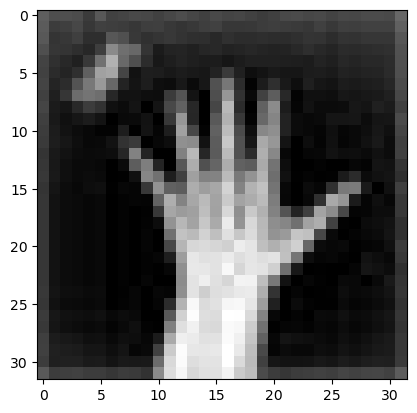

Number of pixels in each image: 1024
Pixel value range: max, 1.0 min, -1.0


In [27]:
print("Batch size:", train_loader.batch_size)
print("Number of batches:", len(train_loader))
print("Total number of images:", train_loader.batch_size * len(train_loader))

# Retrieve the first batch of images
images = next(iter(train_loader))

print("Image shape:", images.shape)  # Shape is [batch_size, n_channels, height, width]

# Plot the first image in the batch
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

# Number of pixels in the image
print("Number of pixels in each image:", images.shape[2] * images.shape[3])

# Range of pixel values
print("Pixel value range: max,", images.max().item(), "min,", images.min().item())

## Network design and implementation

I reduced the spatial dimension to 2x2 in this model. This is becuase 4x4 would capture more detailed data which could lead to overfitting with the training data and wont validate well with unseen data. I also normalised my images to be betwee -1 and 1 so the tanh function was more appropriate to use.

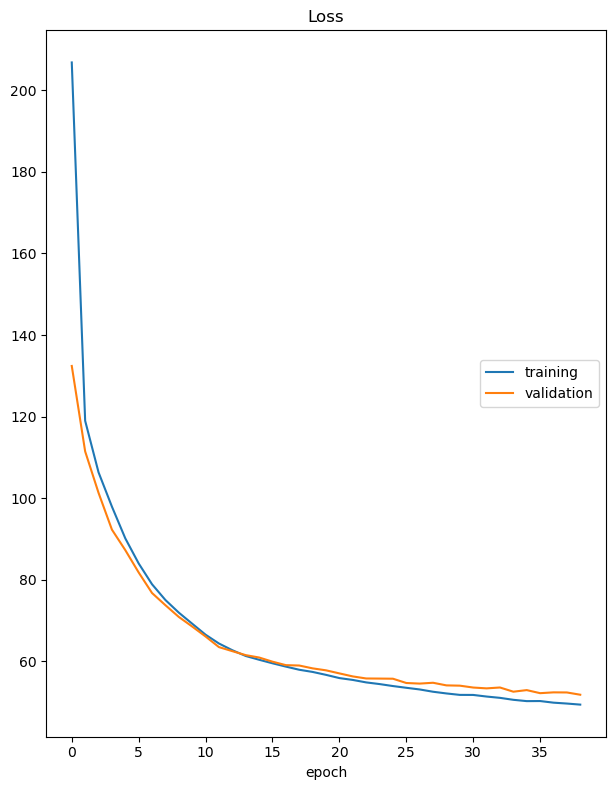

Loss
	training         	 (min:   49.357, max:  206.849, cur:   49.357)
	validation       	 (min:   51.781, max:  132.411, cur:   51.781)


In [29]:
from vae_model import VAE, vae_loss
import torch.optim as optim
from train_vae import train, validate
from livelossplot import PlotLosses
liveloss = PlotLosses()

# Instantiate the model
vae = VAE().to(device)

# Initialize the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 75

for epoch in range(1, num_epochs + 1):
    train_loss = train(vae, device, train_loader, optimizer)
    val_loss = validate(vae, device, test_loader)

    # Update the livelossplot with current loss values
    liveloss.update({
        'loss': train_loss,
        'val_loss': val_loss
    })

    # Render the plot
    liveloss.send()



I have added convolutional layers in both encoder and decoder to effectively learn spatial features.



The model employs the reparameterization trick for efficient training and uses a combination of MSE and KL divergence for the loss function. Future improvements could include adding batch normalization for enhanced training stability, experimenting with alternative loss functions like binary cross-entropy to potentially improve image quality, and monitoring separate components of the loss for deeper insights into the model's learning dynamics. Regular visualization of reconstructed images during training is planned to assess and guide model performance optimization.

I also noticed that reducing to a spatial dimension of 2x2 led to lower test loss and I have been testing this with 10 epochs. The model trained faster also. I tested this for a latent space dimension of 4x4 and 2x2 and will be exploring this is the hyperparameter tuning.

## Training and evaluation loops

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

I am using the best hyperparamters found within the hyperparam tuning notebook in this directory. I ran an extensive grid search and explored as muhc as the time constraints would allow.

## Generate 300 new samples with your trained network

##### Compare with the test set:

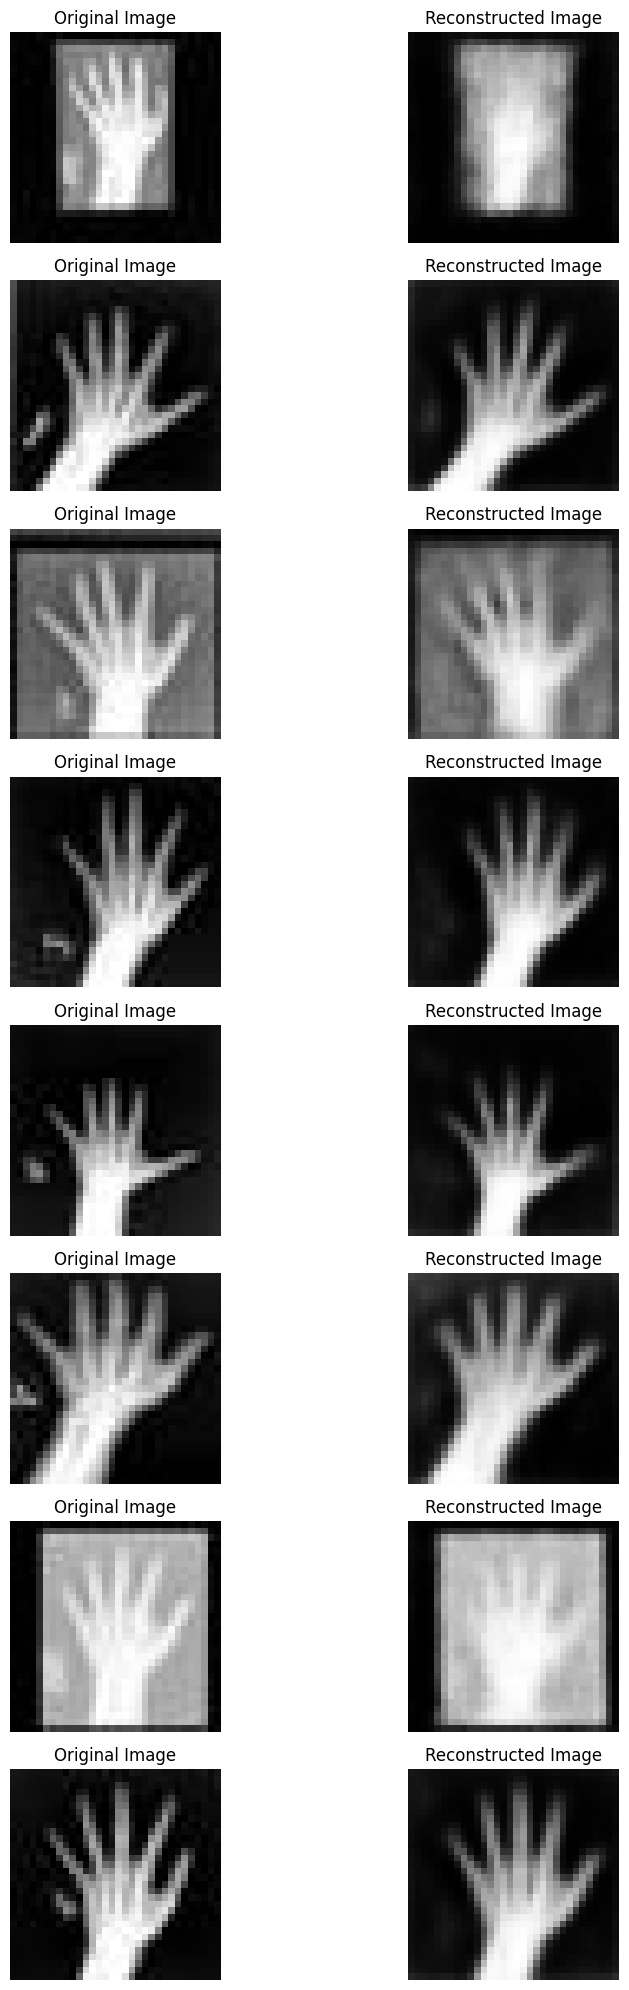

In [16]:
vae.eval()  # Set the model to evaluation mode

# Select 8 test images
test_images = next(iter(test_loader))[:8].to(device)

# Get reconstructed images
with torch.no_grad():
    reconstructed, _, _ = vae(test_images)

# Convert images to numpy for visualization
test_images = test_images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plotting
fig, axes = plt.subplots(8, 2, figsize=(10, 20))
for i in range(8):
    # Original Image
    axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Reconstructed Image
    axes[i, 1].imshow(reconstructed[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

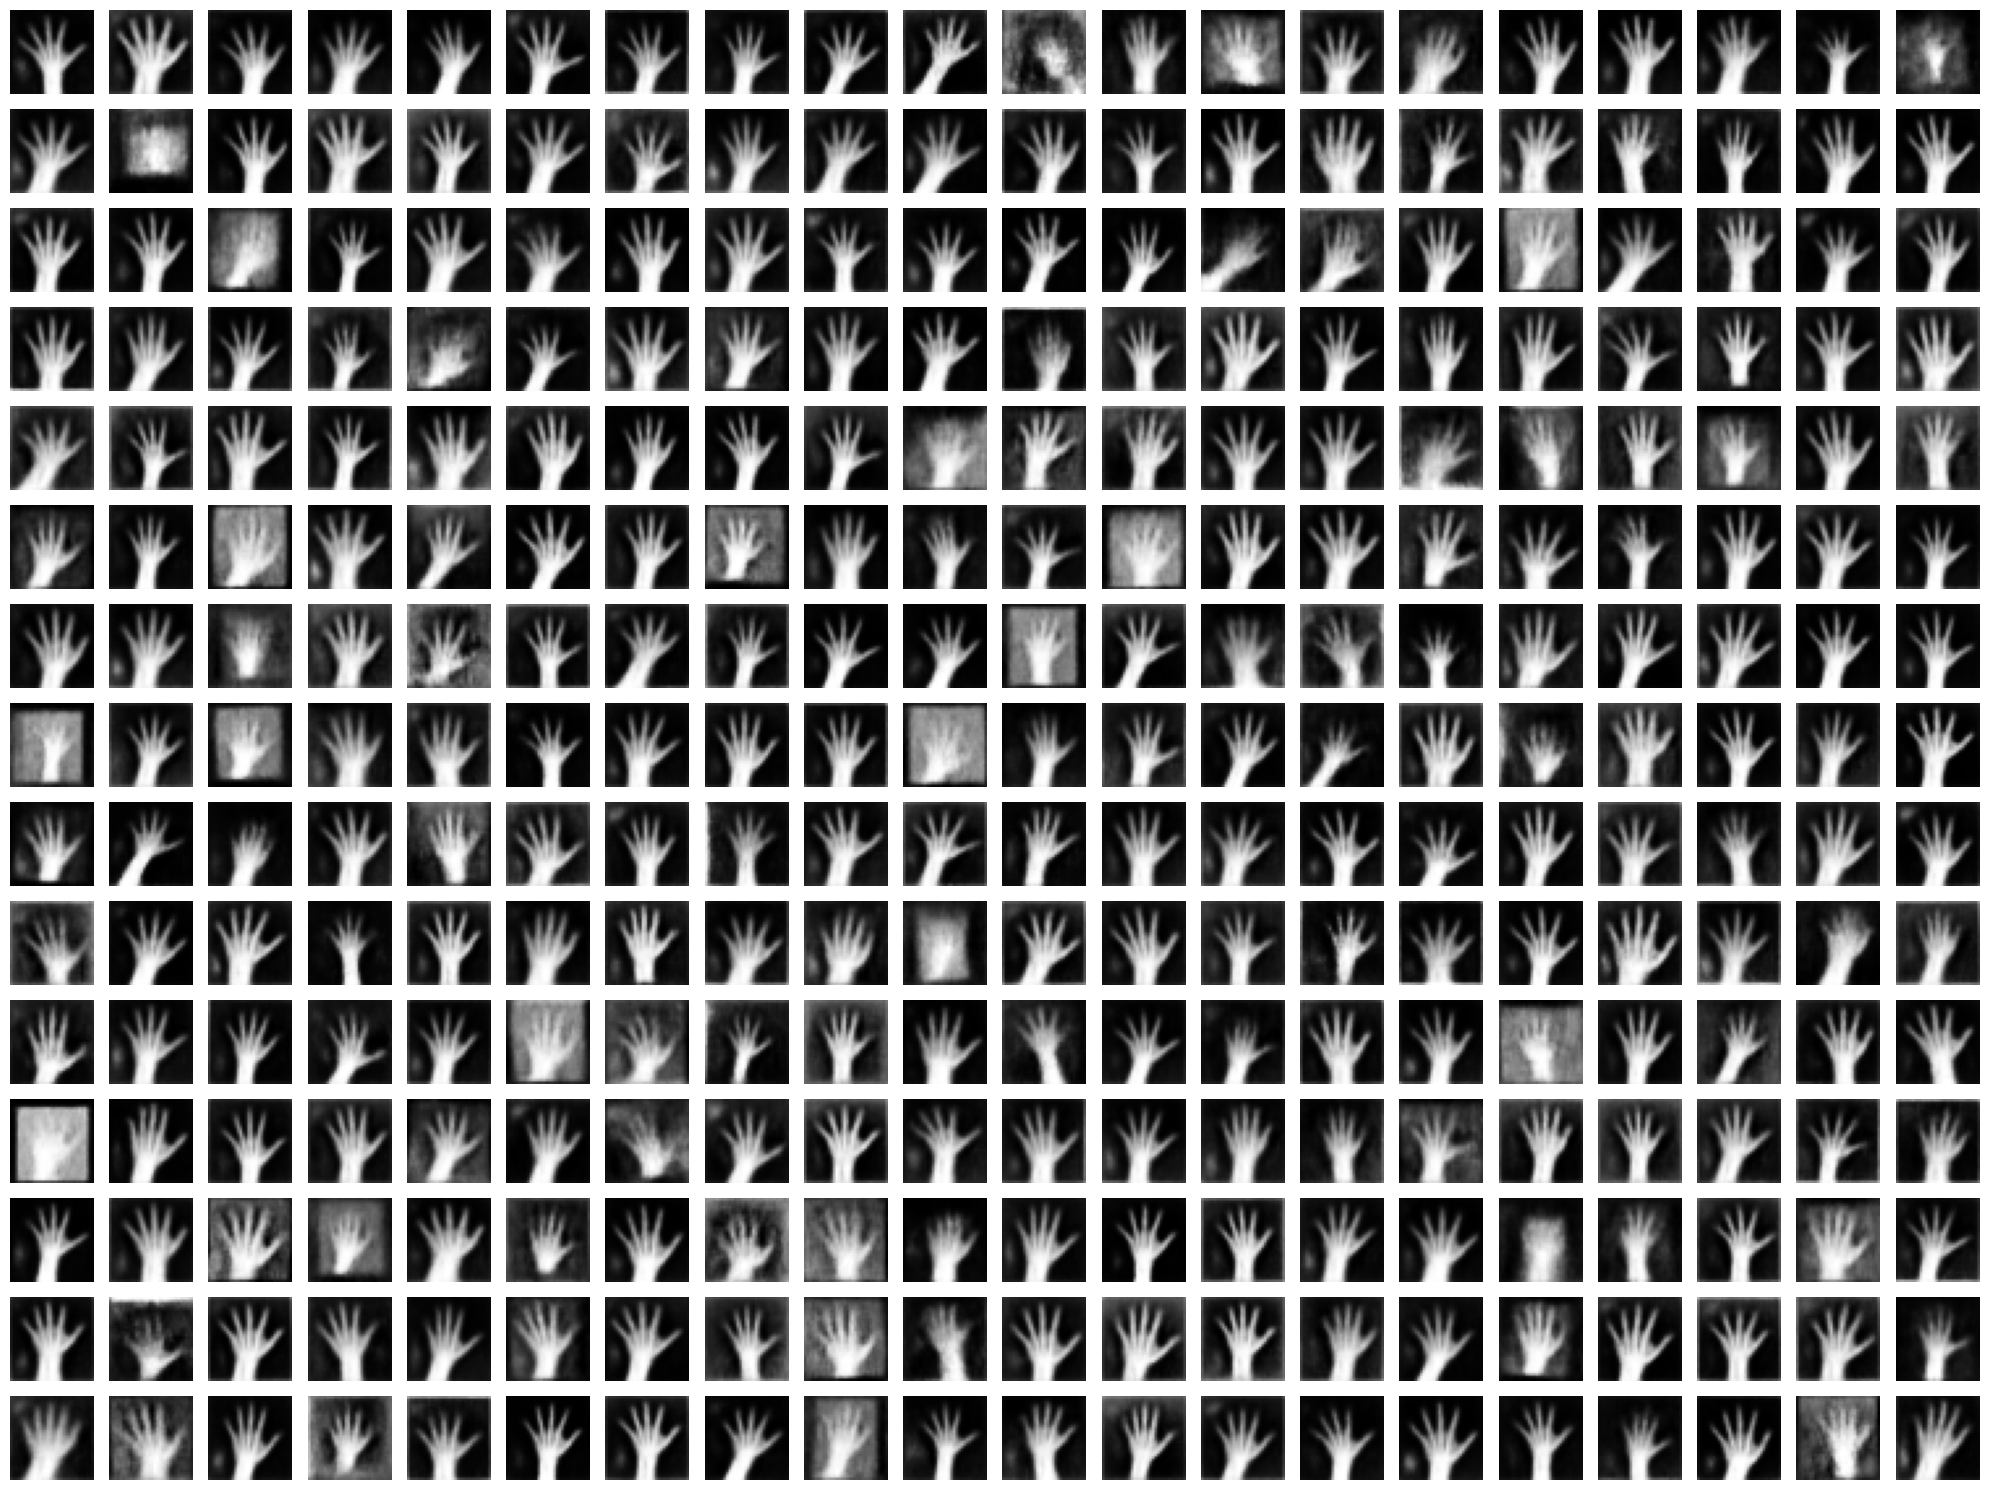

In [13]:
def generate_images(num_samples=300, latent_dim=128):
    vae.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = vae.decode(z).cpu()

        # Postprocess samples if necessary (e.g., un-normalize)
        samples = (samples + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
        return samples

generated_images = generate_images()

# Visualizing 300 generated images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=15, ncols=20, figsize=(20, 15))
for i in range(15):
    for j in range(20):
        ax[i, j].imshow(generated_images[i * 20 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

In [14]:
save_dir = 'data/VAE_hands'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [15]:
# Assuming `generated_images` contains your 300 images
# and `save_dir` is the directory where you want to save them

for i, image in enumerate(generated_images):
    save_path = os.path.join(save_dir, f'hand_{i}.png')
    plt.imsave(save_path, image.squeeze(), cmap='gray')